In [1]:
import os
import plotly.graph_objs as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, metrics
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Load Data

In [2]:
dfMult = pd.read_csv('tictac_multi.txt', sep=' ')
dfMult.rename(columns={'1': '1I', '-1': '2I', '0': '3I', '0.1': '4I', 
                   '0.2':'5I','0.3':'6I','0.4':'7I', '1.1':'8I', '0.5':'9I', '0.6':'1O',
                     '0.7':'2O', '0.8':'3O', '0.9':'4O', '0.10':'5O', '0.11':'6O', '1.2':'7O',
                         '0.12':'8O', '1.3':'9O'}, inplace=True)
dfMult

,1I,2I,3I,4I,5I,6I,7I,8I,9I,1O,2O,3O,4O,5O,6O,7O,8O,9O,Unnamed: 18
0,1,0,1,0,0,0,0,-1,0,0,1,0,1,1,1,1,0,1,NaN
1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,NaN
2,0,1,1,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,NaN
3,1,1,-1,0,0,0,0,-1,0,0,0,0,1,0,1,1,0,1,NaN
4,1,0,0,0,-1,0,0,1,-1,0,0,1,0,0,1,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6545,-1,0,1,1,1,-1,0,0,0,0,0,0,0,0,0,1,0,0,NaN
6546,1,0,1,-1,1,1,-1,0,-1,0,0,0,0,0,0,0,1,0,NaN
6547,-1,-1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,NaN
6548,0,1,1,-1,-1,1,0,1,-1,1,0,0,0,0,0,0,0,0,NaN


In [3]:
multData = np.loadtxt('tictac_multi.txt')
multData

array([[ 1., -1.,  0., ...,  1.,  0.,  1.],
       [ 1.,  0.,  1., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [-1., -1.,  0., ...,  0.,  0.,  1.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1., -1., ...,  0.,  0.,  1.]])

# Train Models

- Need to work on correct CV sciore for models
    - Regression algo ouputs continuous values so cross-val-score doesn't work as intended

### Misc Helper Functions

In [4]:
def RoundPreds(y_pred):
    for i in range(len(y_pred)):
            for j in range(len(y_pred[i])):
                y_pred[i][j] = round(y_pred[i][j]) 
    return y_pred


# Custom CV function needed due to regressions continuous output values
# Unable to round values using scikit's cv functions
# This code has been adapted from the textbook

from sklearn.model_selection import KFold
from sklearn.base import clone

def CustomCV(X_train, y_train, model):
    accs = []
    skfolds = KFold(n_splits = 10, random_state = 42, shuffle=True)
    
    for train_index, test_index in skfolds.split(X_train,y_train):
        cloneReg = clone(model)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
        
        cloneReg.fit(X_train_folds, y_train_folds)
        y_pred = cloneReg.predict(X_test_fold)
        
        # Round all predictions (regression used, so predictions are continuous values... need to get whole # value)
        y_pred = RoundPreds(y_pred)
                
        correct_predictions = y_pred==y_test_fold
        acc = np.mean(correct_predictions)
        accs.append(acc)
    
    print("CV Score: {0} %" .format(np.mean(accs)*100))

## KNN Regression

In [5]:
from sklearn.neighbors import KNeighborsRegressor

CV Score: 95.75275657336726 %


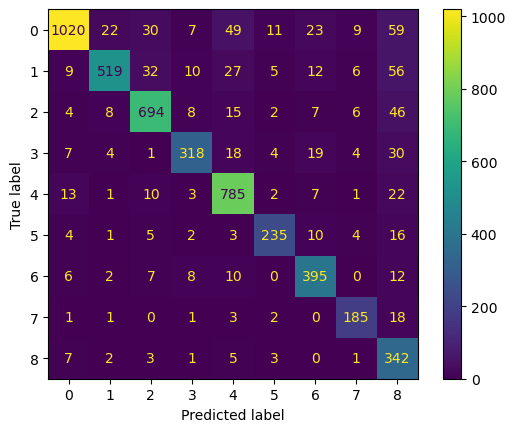

Accuracy :96.86414102890075 %


In [6]:
xMult = multData[:, :9]
yMult = multData[:, 9:]

# Taking 20% data as test and 80% as training data. 
X_tr, X_test, y_tr, y_test = train_test_split(xMult, yMult, test_size = 0.2)

# FIT AND CROSS VALIDADTE
knnReg = KNeighborsRegressor(algorithm='auto', n_neighbors=19, weights='distance').fit(X_tr, y_tr)

# Get CV-Score
np.random.shuffle(multData)
CustomCV(X_tr, y_tr, knnReg)

# CONFUSION MATRIX
y_pred = cross_val_predict(knnReg, X_tr, y_tr, cv=5)

# Round all predictions (regression used, so predictions are continuous values... need to get whole # value)
y_pred = np.round(y_pred)
        
# Modify y_pred so that the optimal position to move to is the first position that's marked optimal
y_predT = []
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        if y_pred[i][j] > 0:
            y_predT.append(j)
            break
        elif j == (len(y_pred[i])-1):
            y_predT.append(j)

# Modify training matrix (get optimal index) to allow for CFM
y_trT = np.argmax(y_tr, axis=1)

cfm = metrics.confusion_matrix(y_trT, y_predT)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cfm)
cm_display.plot()
plt.show() 

# Accuracy
# predict w/ X_test
y_actual = knnReg.predict(X_test)

# Round all predictions (regression used, so predictions are continuous values... need to get whole # value)
y_actual = RoundPreds(y_actual)
        
# compare to y_test
correct_predictions = y_actual==y_test
Accuracy_final = np.mean(correct_predictions)
print(f"Accuracy :{Accuracy_final*100} %")

## Linear Regression (Need Help)

In [7]:
from sklearn.linear_model import LinearRegression

CV Score: 78.34605597964376 %


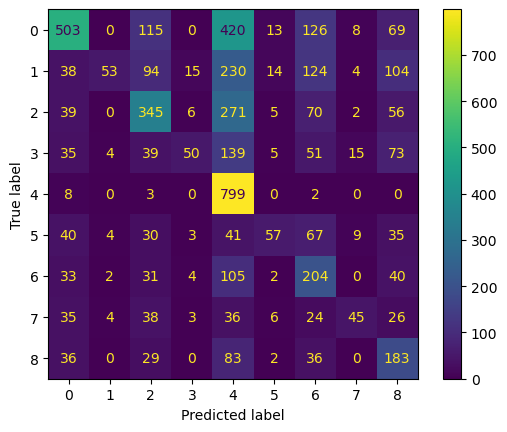

Accuracy :44.01220442410374 %


In [8]:
xMult = multData[:, :9]
yMult = multData[:, 9:]

# Taking 20% data as test and 80% as training data. 
X_tr, X_test, y_tr, y_test = train_test_split(xMult, yMult, test_size = 0.2)

# train 9 models, each regressing on individual output index
lin_models = []
for i in range(9):
    # Create and fit a linear regression model for the i-th output dimension
    model = LinearRegression()
    model.fit(X_tr, y_tr[:, i])  # Training only on the i-th output dimension
    lin_models.append(model)

# CV
model_accs = []
for model in lin_models:
    accs = []
    skfolds = KFold(n_splits = 10, random_state = 42, shuffle=True)
    
    for train_index, test_index in skfolds.split(X_tr,y_tr):
        cloneReg = clone(model)
        X_train_folds = X_tr[train_index]
        y_train_folds = y_tr[train_index]
        X_test_fold = X_tr[test_index]
        y_test_fold = y_tr[test_index]
        
        cloneReg.fit(X_train_folds, y_train_folds)
        y_pred = cloneReg.predict(X_test_fold)
        
        # Round all predictions (regression used, so predictions are continuous values... need to get whole # value)
        y_pred = RoundPreds(y_pred)
                
        correct_predictions = y_pred==y_test_fold
        acc = np.mean(correct_predictions)
        accs.append(acc)
        
    model_accs.append(np.mean(accs))
    
print("CV Score: {0} %" .format(np.mean(model_accs)*100))

# CONFUSION MATRIX

# Predict outputs for each linear model
y_pred = []
for board in X_tr:
    preds = []
    for model in lin_models:
        preds.append(model.predict([board])[0])  # Adjusted to get prediction from model
    for i in range(9):
        optimal_move = np.argmax(preds)
        if board[optimal_move] == 0:
            y_pred.append(optimal_move)
            break
        else:
            preds[optimal_move] = 0

# Modify training matrix (get optimal index) to allow for CFM
y_trT = np.argmax(y_tr, axis=1)

# Create confusion matrix
cfm_linear = metrics.confusion_matrix(y_trT, y_pred)

# Display confusion matrix
cm_display_linear = metrics.ConfusionMatrixDisplay(confusion_matrix=cfm_linear)
cm_display_linear.plot()
plt.show()

# Accuracy
# Predict outputs for each linear model
y_pred = []
#for each row in X_test, predict w/ each model, find highest confidence index that is empty
for board in X_test:
    preds = []
    for model in lin_models:
        preds.append(model.predict([board])[0])
    for i in range(9):
        optimal_move = np.argmax(preds)
        if board[optimal_move] == 0:
            y_pred.append(optimal_move)
            break
        else:
            preds[optimal_move] = 0
            
# Modify training matrix (get optimal index) to allow for CFM
y_testT = np.argmax(y_test, axis=1)

# compare to y_test
correct_predictions = y_pred==y_testT
Accuracy_final = np.mean(correct_predictions)

print(f"Accuracy :{Accuracy_final*100} %")

## MLP Regression

In [9]:
from sklearn.neural_network import MLPRegressor

CV Score: 91.55640373197625 %


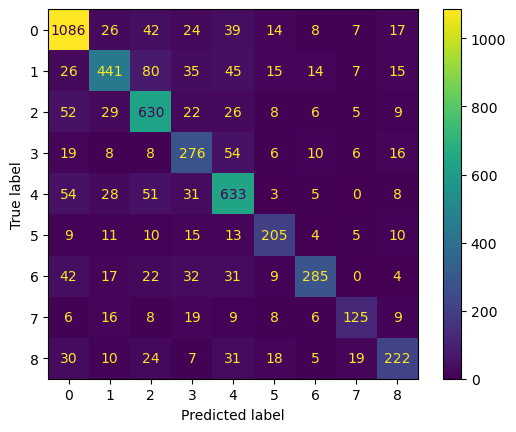

Accuracy :90.76192897703194 %


In [10]:
xMult = multData[:, :9]
yMult = multData[:, 9:]

# Taking 20% data as test and 80% as training data. 
X_tr, X_test, y_tr, y_test = train_test_split(xMult, yMult, test_size = 0.2)

# FIT AND CROSS-VALIDATE MODEL
mlpReg = MLPRegressor(alpha=1e-5, max_iter = 500).fit(X_tr, y_tr)

# Get CV-Score
np.random.shuffle(multData)
CustomCV(X_tr, y_tr, mlpReg)

# CONFUSION MATRIX
y_pred = cross_val_predict(mlpReg, X_tr, y_tr, cv=10)

# Round all predictions (regression used, so predictions are continuous values... need to get whole # value)
y_pred = RoundPreds(y_pred)

# Modify y_pred so that the optimal position to move to is the first position that's marked optimal
y_predT = []
for i in range(len(y_pred)):
    for j in range(len(y_pred[i])):
        if y_pred[i][j] > 0:
            y_predT.append(j)
            break
        elif j == (len(y_pred[i])-1):
            y_predT.append(j)

# Modify training matrix (get optimal index) to allow for CFM
y_trT = np.argmax(y_tr, axis=1)

cfm = metrics.confusion_matrix(y_trT, y_predT)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cfm)
cm_display.plot()
plt.show() 

# Accuracy
# predict w/ X_test
y_actual = mlpReg.predict(X_test)

# Round all predictions (regression used, so predictions are continuous values... need to get whole # value)
y_actual = RoundPreds(y_actual)

# compare to y_test
correct_predictions = y_actual==y_test
Accuracy_final = np.mean(correct_predictions)
print(f"Accuracy :{Accuracy_final*100} %")